In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression  
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA

Using TensorFlow backend.


In [2]:
# Read the dataset

df = pd.read_csv("cotton_production.csv",parse_dates=['Year'],index_col=0)

In [3]:
df

,Area,Production,Kg/Hectare,irrigation
Year,,,,
1947-01-01,4424.0,3336,132.0,NaN
1950-01-01,5882.0,3044,88.0,8.2
1951-01-01,6556.0,3276,85.0,9.1
1952-01-01,6359.0,3341,89.0,8.5
1953-01-01,6987.0,4125,100.0,8.4
...,...,...,...,...
2013-01-01,11960.0,35902,510.0,NaN
2014-01-01,12846.0,34805,461.0,NaN
2015-01-01,12292.0,30005,415.0,NaN


In [4]:
# Shows the shape of the dataset 

df.shape

(69, 4)

In [5]:
# Drop all the columns except year and Production.

df1=df.drop(['Area','Kg/Hectare','irrigation'],axis=1)
df1

,Production
Year,
1947-01-01,3336
1950-01-01,3044
1951-01-01,3276
1952-01-01,3341
1953-01-01,4125
...,...
2013-01-01,35902
2014-01-01,34805
2015-01-01,30005


In [6]:
# Check For any null values

df1.isnull().sum()

Production    0
dtype: int64

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 1947-01-01 to 2017-01-01
Data columns (total 1 columns):
Production    69 non-null int64
dtypes: int64(1)
memory usage: 1.1 KB


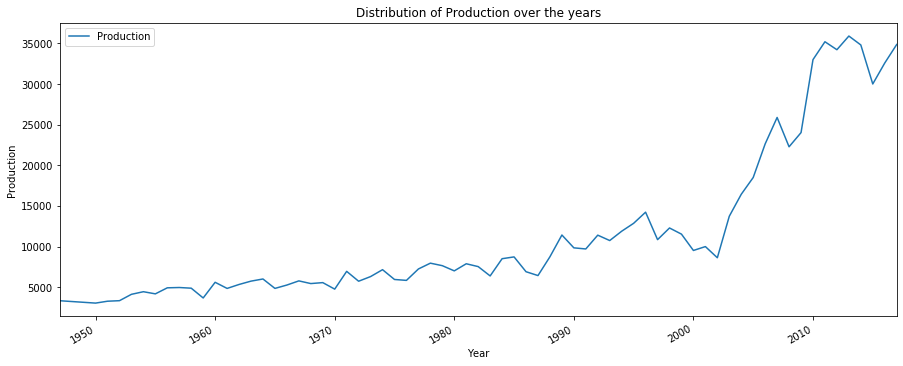

In [8]:
# Plot the Cotton Production over the years. 

df1.plot(figsize=(15, 6))
plt.title("Distribution of Production over the years")
plt.ylabel("Production")
plt.show()

In [9]:
# Run the Dickey Fuller Test

result = adfuller(df1['Production'])
# Print test statistic
print(result)

(1.4817571299315653, 0.997455667598692, 10, 58, {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}, 1032.0761665461828)


In [12]:
result

(1.4817571299315653,
 0.997455667598692,
 10,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 1032.0761665461828)

#### So, from dicky fuller test we can say that our data is not stationary as the p-value or the test statistics is greater than 5% critical value, which result in not rejecting the null hypothesis.

# Moving Average Method 

In [263]:
# Moving Average
def moving_avg(d, extra_periods, n):
# transform the input into a numpy array

    d = np.array(d)

# Historical period length
    cols=len(d)

# Append np.nan into the demand array to cover future periods    
    d=np.append(d, [np.nan]*extra_periods)

# Define the forecast array
    f = np.full(cols+extra_periods, np.nan)

# Create all the t+1 forecasts until end of historical period 

    for t in range(n, cols+1):
        f[t]= np.mean(d[t-n:t])
        
 # Forecast for all the extra periods       
    f[cols+1:] =f[t]
# Return a  dataframe with demand, forecast, and error
    
    df = pd.DataFrame.from_dict({"Demand":d, "Forecast":f, "Error":f-d})

    return df 

# 3 Year Moving Average

In [264]:
# Calling the function 

df=moving_avg(df1.Production, 5, 3)

In [265]:
df

,Demand,Forecast,Error
0,3336.0,NaN,NaN
1,3044.0,NaN,NaN
2,3276.0,NaN,NaN
3,3341.0,3218.666667,-122.333333
4,4125.0,3220.333333,-904.666667
...,...,...,...
69,NaN,32481.333333,NaN
70,NaN,32481.333333,NaN
71,NaN,32481.333333,NaN
72,NaN,32481.333333,NaN


<module 'matplotlib.pyplot' from 'C:\\Users\\amith\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

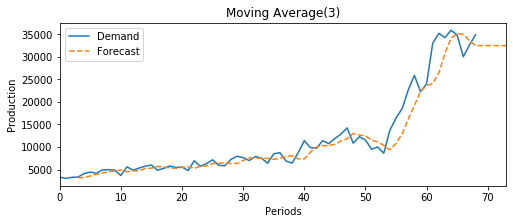

In [266]:
# Plot the values

df.index.name = "Periods"
df[["Demand","Forecast"]].plot(figsize=(8,3),title="Moving Average(3)",style=["-","--"])  
plt.ylabel("Production")
plt

In [267]:
# Print the MAE and RMSE values.

MAE = df["Error"].abs().mean()  
print("MAE:",round(MAE,2)) 
RMSE = np.sqrt((df["Error"]**2).mean())
print("RMSE:",round(RMSE,2))

MAE: 1624.08
RMSE: 2583.21


# 5 Year Moving Average

In [268]:
# Calling the function 

df=moving_avg(df1.Production, 5, 5)
df

,Demand,Forecast,Error
0,3336.0,NaN,NaN
1,3044.0,NaN,NaN
2,3276.0,NaN,NaN
3,3341.0,NaN,NaN
4,4125.0,NaN,NaN
...,...,...,...
69,NaN,33630.2,NaN
70,NaN,33630.2,NaN
71,NaN,33630.2,NaN
72,NaN,33630.2,NaN


<module 'matplotlib.pyplot' from 'C:\\Users\\amith\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

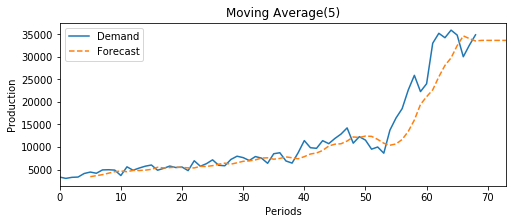

In [269]:
# Plot the values

df.index.name = "Periods"
df[["Demand","Forecast"]].plot(figsize=(8,3),title="Moving Average(5)",style=["-","--"]) 
plt.ylabel("Production")
plt

In [270]:
# Print the MAE and RMSE values.

MAE = df["Error"].abs().mean()  
print("MAE:",round(MAE,2)) 
RMSE = np.sqrt((df["Error"]**2).mean())
print("RMSE:",round(RMSE,2))

MAE: 2073.3
RMSE: 3249.59


# Simple Exponential Smoothing with alpha = 0.77

Here alpha = 0.77 is obtained by doing the solver function in excel by minimizing the value of mae and rmse

In [372]:
# Simple Exponential Smoothing
def simple_exp_smooth(d,extra_periods,alpha):  


  d = np.array(d)  # Transform the input into a numpy array  

  cols = len(d)  # Historical period length  

  d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  



  f = np.full(cols+extra_periods,np.nan)  # Forecast array  

  f[0] = d[0]  # initialization of first forecast  

    

  # Create all the t+1 forecasts until end of historical period  

  for t in range(1,cols+1):  

    f[t] = alpha*d[t-1]+(1-alpha)*f[t-1]  
    f[cols+1:] = f[t]  # Forecast for all extra periods  


  df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Error":f-d}) 
  return df


In [373]:
# Calling the function 

df=simple_exp_smooth(df1.Production,5,0.77)
df

,Demand,Forecast,Error
0,3336.0,3336.000000,0.000000
1,3044.0,3336.000000,292.000000
2,3276.0,3111.160000,-164.840000
3,3341.0,3238.086800,-102.913200
4,4125.0,3317.329964,-807.670036
...,...,...,...
69,NaN,34260.777859,NaN
70,NaN,34260.777859,NaN
71,NaN,34260.777859,NaN
72,NaN,34260.777859,NaN


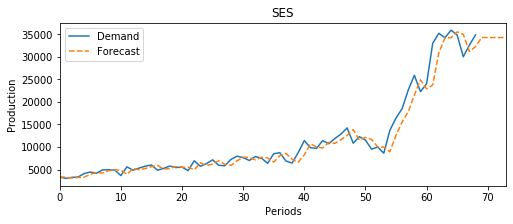

In [374]:
# Plot the values

df.index.name = "Periods"
df[["Demand","Forecast"]].plot(figsize=(8,3),title="SES",style=["-","--"]) 
plt.ylabel("Production")
plt.show()

In [375]:
# Print the MAE and RMSE values.

MAE = df["Error"].abs().mean()  
print("MAE:",round(MAE,2)) 
RMSE = np.sqrt((df["Error"]**2).mean())
print("RMSE:",round(RMSE,2))

MAE: 1385.42
RMSE: 2102.46


# Double Exponential Smoothing with alpha=0.81 and beta = 0.07

Here alpha = 0.81 and beta = 0.07 is obtained by doing the solver function in excel by minimizing the value of mae and rmse

In [376]:
# Double Exponential Smoothing
def double_exp_smooth(d,extra_periods,alpha,beta):  

    d = np.array(d)  # Transform the input into a numpy array  
    cols = len(d)  # Historical period length  
    d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  
# Creation of the level, trend, and forecast arrays
    f= np.full(cols+extra_periods,np.nan)  # Forecast array  
    a = np.full(cols+extra_periods,np.nan)
    b = np.full(cols+extra_periods,np.nan)
# Level and trend initialization 
    a[0] = d[0]
    b[0] = d[1] -d[0]

    
  # Create all the t+1 forecasts until end of historical period  

    for t in range(1,cols):  
        f[t] = a[t-1]+ b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1] + b[t-1])
        b[t] = beta*(a[t] - a[t-1]) + (1-beta)* b[t-1]

# Forecast for all extra periods  
    for t in range(cols, cols+extra_periods):
        f[t] = a[t-1] + b[t-1]
        a[t] = f[t]
        b[t] = b[t-1]


    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Level": a, "Trend": b, "Error":f-d}) 
    return df

In [377]:
# Calling the function 

df= double_exp_smooth(df1.Production,5,0.81,0.07)
df

,Demand,Forecast,Level,Trend,Error
0,3336.0,NaN,3336.000000,-292.000000,NaN
1,3044.0,3044.000000,3044.000000,-292.000000,0.000000
2,3276.0,2752.000000,3176.440000,-262.289200,-524.000000
3,3341.0,2914.150800,3259.898652,-238.086850,-426.849200
4,4125.0,3021.811802,3915.394242,-175.536080,-1103.188198
...,...,...,...,...,...
69,NaN,35454.055551,35454.055551,894.642903,NaN
70,NaN,36348.698454,36348.698454,894.642903,NaN
71,NaN,37243.341356,37243.341356,894.642903,NaN
72,NaN,38137.984259,38137.984259,894.642903,NaN


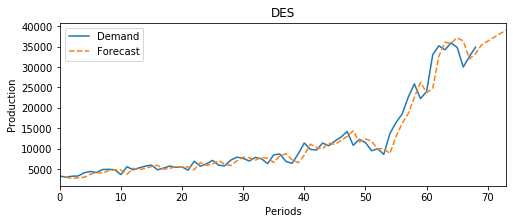

In [378]:
# Plot the values

df.index.name = "Periods"
df[["Demand","Forecast"]].plot(figsize=(8,3),title="DES",style=["-","--"])
plt.ylabel("Production")
plt.show()

In [379]:
# Print the MAE and RMSE values.

MAE = df["Error"].abs().mean()  
print("MAE:",round(MAE,2)) 
RMSE = np.sqrt((df["Error"]**2).mean())
print("RMSE:",round(RMSE,2))

MAE: 1388.81
RMSE: 2043.45


 So on comparing all the moving average methods and simple and double exponential technique, 3  Year moving average method had a better value for mae and rmse which was 1624.08 and 2583.21 respectively.  

# Machine Learning Models

# Prepare the Dataset for Machine Learning

In [364]:
# Create 12 years of lag values to predict current observation
df = pd.DataFrame()
print(df)
for i in range(12,0,-1):
    df[['t-'+str(i)]] = df1.shift(i)
print(df)

Empty DataFrame
Columns: []
Index: []
               t-12     t-11     t-10      t-9      t-8      t-7      t-6  \
Year                                                                        
1947-01-01      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1950-01-01      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1951-01-01      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1952-01-01      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1953-01-01      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...             ...      ...      ...      ...      ...      ...      ...   
2013-01-01   9997.0   8624.0  13729.0  16429.0  18499.0  22632.0  25884.0   
2014-01-01   8624.0  13729.0  16429.0  18499.0  22632.0  25884.0  22276.0   
2015-01-01  13729.0  16429.0  18499.0  22632.0  25884.0  22276.0  24022.0   
2016-01-01  16429.0  18499.0  22632.0  25884.0  22276.0  24022.0  33000.0   
2017-01-01  18499.0  22632.0  25884.0 

In [365]:
# Create column t (original column)
df['t'] = df1.values
print(df.head(13))

              t-12    t-11    t-10     t-9     t-8     t-7     t-6     t-5  \
Year                                                                         
1947-01-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1950-01-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1951-01-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1952-01-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1953-01-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1954-01-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN  3336.0   
1955-01-01     NaN     NaN     NaN     NaN     NaN     NaN  3336.0  3044.0   
1956-01-01     NaN     NaN     NaN     NaN     NaN  3336.0  3044.0  3276.0   
1957-01-01     NaN     NaN     NaN     NaN  3336.0  3044.0  3276.0  3341.0   
1958-01-01     NaN     NaN     NaN  3336.0  3044.0  3276.0  3341.0  4125.0   
1959-01-01     NaN     NaN  3336.0  3044.0  3276.0  3341.0  4125

In [366]:
# Create a new subsetted dataframe, removing Nans from first 12 rows
df2 = df[13:]
print(df2)

               t-12     t-11     t-10      t-9      t-8      t-7      t-6  \
Year                                                                        
1962-01-01   3044.0   3276.0   3341.0   4125.0   4445.0   4181.0   4924.0   
1963-01-01   3276.0   3341.0   4125.0   4445.0   4181.0   4924.0   4962.0   
1964-01-01   3341.0   4125.0   4445.0   4181.0   4924.0   4962.0   4879.0   
1965-01-01   4125.0   4445.0   4181.0   4924.0   4962.0   4879.0   3676.0   
1966-01-01   4445.0   4181.0   4924.0   4962.0   4879.0   3676.0   5604.0   
1967-01-01   4181.0   4924.0   4962.0   4879.0   3676.0   5604.0   4850.0   
1968-01-01   4924.0   4962.0   4879.0   3676.0   5604.0   4850.0   5336.0   
1969-01-01   4962.0   4879.0   3676.0   5604.0   4850.0   5336.0   5747.0   
1970-01-01   4879.0   3676.0   5604.0   4850.0   5336.0   5747.0   6011.0   
1971-01-01   3676.0   5604.0   4850.0   5336.0   5747.0   6011.0   4852.0   
1972-01-01   5604.0   4850.0   5336.0   5747.0   6011.0   4852.0   5266.0   

In [367]:
# Split Data into dependent(target) and independent(features) variables

data = df2.values
# Lagged variables (features) and original time series data (target)
X2= data[:,0:-1]  # slice all rows and start with column 0 and go up to but not including the last column
Y2 = data[:,-1]  # slice all rows and last column, essentially separating out 't' column

In [368]:
# Split the data into train and test with a test ratio of 0.2.

X_train,X_test,y_train,y_test = train_test_split(X2,Y2,test_size=0.2, random_state = 0)

In [ ]:
# Scale the data

minma = MinMaxScaler()
minma.fit(X_train)
X_train = minma.transform(X_train)
X_test = minma.transform(X_test)

# Linear Regression Model

In [369]:
reg = LinearRegression()
reg = reg.fit(X_train,y_train)
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)
print("Accuracy for Test set: "+"{:.2f}".format(reg.score(X_test,y_test)))
print("Accuracy for Training set: "+"{:.2f}".format(reg.score(X_train,y_train)))

Accuracy for Test set: 0.84
Accuracy for Training set: 0.98


     Demand      Forecast
0   25884.0  27051.267448
1   12861.0  14010.986177
2    8624.0  10765.327331
3    8744.0   7390.843928
4    6309.0   5554.623123
5    6011.0   5031.625642
6   11888.0  10843.741210
7   18499.0  18459.474699
8   22276.0  30411.874735
9   11403.0  11196.703542
10   5266.0   4271.130219
11   5735.0   7038.074879


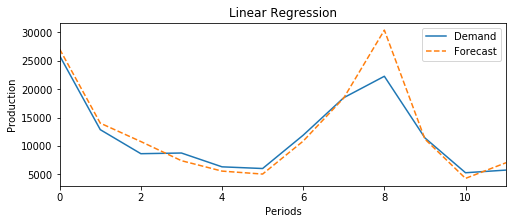

In [285]:
# Plot the Values

df = pd.DataFrame.from_dict({"Demand":y_test,"Forecast":test_pred,}) 
print(df)
df.index.name = "Periods"
df[["Demand","Forecast"]].plot(figsize=(8,3),title="Linear Regression",style=["-","--"]) 
plt.ylabel("Production")
plt.show()

In [286]:
# Print the MAE and RMSE values.

MAE = mean_absolute_error(y_test,test_pred)
print("MAE:",round(MAE,2))
RMSE = math.sqrt(mean_squared_error(y_test,test_pred))
print("RMSE:",round(RMSE,2))

MAE: 1605.78
RMSE: 2592.37


# Random Forest Regressor 

In [288]:
rf_reg = RandomForestRegressor(n_estimators=200)
rf_reg.fit(X_train,y_train)
train_pred=rf_reg.predict(X_train)
test_pred=rf_reg.predict(X_test)
print("Accuracy for Test set: "+"{:.2f}".format(rf_reg.score(X_test,y_test)))
print("Accuracy for Training set: "+"{:.2f}".format(rf_reg.score(X_train,y_train)))

Accuracy for Test set: 0.90
Accuracy for Training set: 0.99


In [289]:
 
# Run grid search
grid = {'n_estimators': [200], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'random_state': [13]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rf_reg.set_params(**g)  # ** is "unpacking" the dictionary
    rf_reg.fit(X_train,y_train)
    test_scores.append(rf_reg.score(X_test,y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])  

# The best test score

0.8919426148528781 {'random_state': 13, 'n_estimators': 200, 'max_features': 10, 'max_depth': 4}


In [290]:
# Use the best hyperparameters from before to fit a random forest model
rf_reg = RandomForestRegressor(n_estimators=200, max_depth=4, max_features = 10, random_state=13)
rf_reg.fit(X_train,y_train)
train_pred=rf_reg.predict(X_train)
test_pred=rf_reg.predict(X_test)
print("Accuracy for Test set: "+"{:.2f}".format(rf_reg.score(X_test,y_test)))
print("Accuracy for Training set: "+"{:.2f}".format(rf_reg.score(X_train,y_train)))

Accuracy for Test set: 0.89
Accuracy for Training set: 0.99


     Demand      Forecast
0   25884.0  20440.292535
1   12861.0  10993.265670
2    8624.0  12453.081473
3    8744.0   8625.978796
4    6309.0   6249.016040
5    6011.0   5455.858771
6   11888.0  10365.857161
7   18499.0  16730.703789
8   22276.0  23135.719778
9   11403.0  10215.740128
10   5266.0   5554.604256
11   5735.0   5908.700919


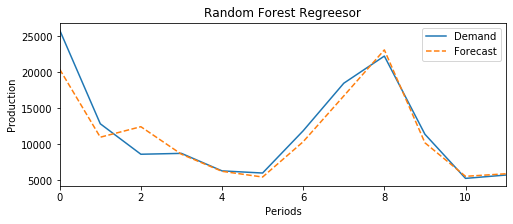

In [291]:
# Plot the Values

df = pd.DataFrame.from_dict({"Demand":y_test,"Forecast":test_pred,}) 
print(df)
df.index.name = "Periods"
df[["Demand","Forecast"]].plot(figsize=(8,3),title="Random Forest Regreesor",style=["-","--"])  
plt.ylabel("Production")
plt.show()

In [292]:
# Print the MAE and RMSE values.

MAE = mean_absolute_error(y_test,test_pred)
print("MAE:",round(MAE,2))
RMSE = math.sqrt(mean_squared_error(y_test,test_pred))
print("RMSE:",round(RMSE,2))

MAE: 1472.78
RMSE: 2156.69


# Decision Tree Regressor

In [293]:
dec_reg = DecisionTreeRegressor()
dec_reg.fit(X_train,y_train)
train_pred = dec_reg.predict(X_train)
test_pred=dec_reg.predict(X_test)
print("Accuracy for Test set: "+"{:.2f}".format(dec_reg.score(X_test,y_test)))
print("Accuracy for Training set: "+"{:.2f}".format(dec_reg.score(X_train,y_train)))

Accuracy for Test set: 0.74
Accuracy for Training set: 1.00


In [294]:

for d in [2, 3,4, 5,7,8,10]:
    # Create the tree and fit it
    decision_tree_milk = DecisionTreeRegressor(max_depth=d)
    decision_tree_milk.fit(X_train,y_train)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree_milk.score(X_train,y_train))
    print(decision_tree_milk.score(X_test,y_test), '\n')  # You want the test score to be positive
    
# R-square for train and test scores are below. 

max_depth= 2
0.9767716573396884
0.860501919065742 

max_depth= 3
0.9898456466822748
0.6118146089661751 

max_depth= 4
0.9968495190393731
0.8408259290878585 

max_depth= 5
0.9990744957009378
0.9167026537658317 

max_depth= 7
0.9999903518887773
0.56108834900276 

max_depth= 8
0.9999985874376246
0.8044613924530155 

max_depth= 10
1.0
0.5471665595652664 



In [295]:
# Use the best max_depth 
dec_reg = DecisionTreeRegressor(max_depth=5)
dec_reg.fit(X_train,y_train)
train_pred = dec_reg.predict(X_train)
test_pred=dec_reg.predict(X_test)
print("Accuracy for Test set: "+"{:.2f}".format(dec_reg.score(X_test,y_test)))
print("Accuracy for Training set: "+"{:.2f}".format(dec_reg.score(X_train,y_train)))


Accuracy for Test set: 0.84
Accuracy for Training set: 1.00


     Demand      Forecast
0   25884.0  24022.000000
1   12861.0  11746.333333
2    8624.0  10190.200000
3    8744.0   9706.000000
4    6309.0   7349.000000
5    6011.0   5508.857143
6   11888.0  11746.333333
7   18499.0  10190.200000
8   22276.0  24022.000000
9   11403.0   9706.000000
10   5266.0   5508.857143
11   5735.0   5508.857143


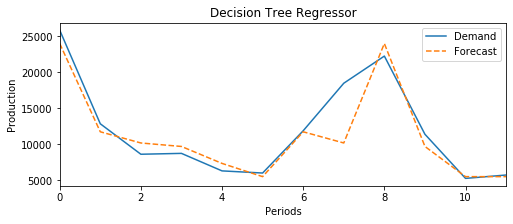

In [296]:
# Plot the Values

df = pd.DataFrame.from_dict({"Demand":y_test,"Forecast":test_pred,}) 
print(df)
df.index.name = "Periods"
df[["Demand","Forecast"]].plot(figsize=(8,3),title="Decision Tree Regressor",style=["-","--"])  
plt.ylabel("Production")
plt.show()

In [297]:
# Print the MAE and RMSE values.

MAE = mean_absolute_error(y_test,test_pred)
print("MAE:",round(MAE,2))
RMSE = math.sqrt(mean_squared_error(y_test,test_pred))
print("RMSE:",round(RMSE,2))

MAE: 1617.46
RMSE: 2653.87


# K Neighbor Regressor

In [298]:
k_reg=KNeighborsRegressor()
k_reg = k_reg.fit(X_train,y_train)
train_pred = k_reg.predict(X_train)
test_pred=k_reg.predict(X_test)
print("Accuracy for Test set: "+"{:.2f}".format(k_reg.score(X_test,y_test)))
print("Accuracy for Training set: "+"{:.2f}".format(k_reg.score(X_train,y_train)))

Accuracy for Test set: 0.73
Accuracy for Training set: 0.97


In [299]:
# Print the MAE and RMSE values.

MAE = mean_absolute_error(y_test,test_pred)
print("MAE:",round(MAE,2))
RMSE = math.sqrt(mean_squared_error(y_test,test_pred))
print("RMSE:",round(RMSE,2))

MAE: 2320.8
RMSE: 3431.05


     Demand  Forecast
0   25884.0   16520.0
1   12861.0   11210.0
2    8624.0   12241.0
3    8744.0    8524.4
4    6309.0    6752.0
5    6011.0    5732.4
6   11888.0    8716.0
7   18499.0   14461.4
8   22276.0   24970.2
9   11403.0    9500.2
10   5266.0    5280.6
11   5735.0    6190.2


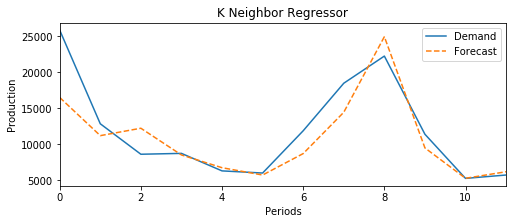

In [300]:
# Plot the Values

df = pd.DataFrame.from_dict({"Demand":y_test,"Forecast":test_pred,}) 
print(df)
df.index.name = "Periods"
df[["Demand","Forecast"]].plot(figsize=(8,3),title="K Neighbor Regressor",style=["-","--"])
plt.ylabel("Production")
plt.show()

# Gradient Boosted Regression Model 

In [301]:
gbr = GradientBoostingRegressor(max_features=7,
                                learning_rate=0.01,
                                n_estimators=500,
                                subsample=0.6,
                                random_state=99)

gbr = gbr.fit(X_train,y_train)
train_pred = gbr.predict(X_train)
test_pred=gbr.predict(X_test)
print("Accuracy for Test set: "+"{:.2f}".format(k_reg.score(X_test,y_test)))
print("Accuracy for Training set: "+"{:.2f}".format(k_reg.score(X_train,y_train)))

Accuracy for Test set: 0.73
Accuracy for Training set: 0.97


In [302]:
# Print the MAE and RMSE values.

MAE = mean_absolute_error(y_test,test_pred)
print("MAE:",round(MAE,2))
RMSE = math.sqrt(mean_squared_error(y_test,test_pred))
print("RMSE:",round(RMSE,2))

MAE: 1456.49
RMSE: 2151.14


     Demand      Forecast
0   25884.0  21179.610066
1   12861.0  10633.935907
2    8624.0  13082.105071
3    8744.0   8864.551566
4    6309.0   6144.208714
5    6011.0   5175.795780
6   11888.0   9976.970465
7   18499.0  18555.062002
8   22276.0  23993.209352
9   11403.0  10306.595915
10   5266.0   5352.558070
11   5735.0   5835.491062


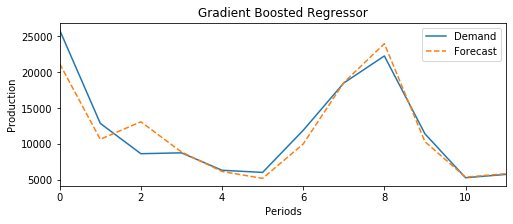

In [363]:
# Plot the Values

df = pd.DataFrame.from_dict({"Demand":y_test,"Forecast":test_pred,}) 
print(df)
df.index.name = "Periods"
df[["Demand","Forecast"]].plot(figsize=(8,3),title="Gradient Boosted Regressor",style=["-","--"]) 
plt.ylabel("Production")
plt.show()

# ARIMA model  

In [305]:

for p in range(4):
# Loop over q values from 0-3
    for q in range(4):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = ARIMA(df1['Production'], order=(p,1,q))
            results = model.fit()
        
            # Print p, q, AIC, BIC
            print(p, q, results.aic, results.bic)
        
        except:
            print(p, q, None, None)

0 0 1229.4494619223387 1233.8884773326909
0 1 1231.2314781147115 1237.89000123024
0 2 1228.5668342508432 1237.4448650715476
0 3 1228.591651396818 1239.6891899226985
1 0 1231.344624649853 1238.0031477653813
1 1 None None
1 2 None None
1 3 None None
2 0 1229.139752349497 1238.0177831702015
2 1 1228.79326668169 1239.8908052075706
2 2 None None
2 3 None None
3 0 1226.6043971388062 1237.7019356646867
3 1 1228.6032282587105 1241.920274489767
3 2 None None
3 3 1220.5628193887069 1238.3188810301158


 ARIMA has low aic for p = 3 and q = 3

In [306]:
# Instantiate the model
df2 = df1.values
arma = ARIMA(df2, order=(3,1,3))

In [307]:
model_arima= arma.fit(disp=0)
print(model_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   68
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -602.281
Method:                       css-mle   S.D. of innovations           1630.628
Date:                Mon, 13 Apr 2020   AIC                           1220.563
Time:                        18:43:50   BIC                           1238.319
Sample:                             1   HQIC                          1227.598
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        431.7573    247.798      1.742      0.086     -53.919     917.433
ar.L1.D.y     -0.3089      0.333     -0.928      0.357      -0.961       0.343
ar.L2.D.y     -0.9304      0.104     -8.930      0.0

In [308]:
pred =model_arima.predict()
pred

array([  431.75727418,   400.59800139,   576.90918736,   213.95828103,
         475.68358691,   405.82712321,   501.47007585,   472.09018558,
          88.30007183,   575.1014853 ,   377.43409288,   499.03450238,
        -288.70408101,  1184.64876534,   368.77288661,   -15.87788814,
         250.37739045,   885.68141759,    44.97092714,   132.96258915,
         758.17892347,   302.31063644,   358.0716652 ,   -74.90100021,
        1317.08697435,    73.0643734 ,  -235.61469186,   793.01768142,
         590.79658767,   121.55700973,   538.67348206,   573.39746576,
         129.74626158,   -45.51347606,   808.72267935,   701.64979958,
        -372.67480528,   679.23654143,   732.38487405,  -256.37232792,
         408.61489619,  1533.29327208,   799.22213567, -1366.62934522,
         217.42456821,  2629.67071777,    38.1028373 , -1110.90408172,
         527.07385827,  2266.10125288, -1314.87915951,  -689.39740707,
        1473.7653035 ,   635.71501908,   149.49746202,   -55.32577653,
      

In [309]:
df1.tail(12)

,Production
Year,
2006-01-01,22632
2007-01-01,25884
2008-01-01,22276
2009-01-01,24022
2010-01-01,33000
2011-01-01,35200
2012-01-01,34220
2013-01-01,35902
2014-01-01,34805


In [310]:
# Print the MAE and RMSE values

MAE=np.mean(abs(pred-df2))
print(" MAE:", round(MAE))

RMSE=np.sqrt(((pred-df2)**2).mean())
print(" RMSE:", round(RMSE))

 MAE: 11149.0
 RMSE: 14625.0


Text(0, 0.5, 'Production')

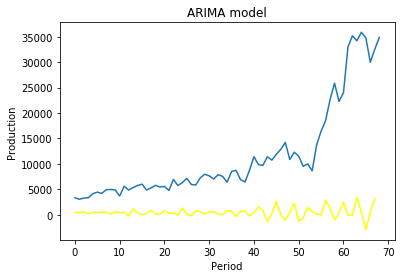

In [311]:
# Plot the Values

plt.plot(df2)
plt.plot(pred , color ='yellow')
plt.title("ARIMA model")
plt.xlabel("Period")
plt.ylabel("Production")

# Prophet Model  

In [27]:
df = pd.read_csv("cotton_production.csv",parse_dates=['Year'])
df2=df.drop(['Area','Kg/Hectare','irrigation'],axis=1)
df2

,Year,Production
0,1947-01-01,3336
1,1950-01-01,3044
2,1951-01-01,3276
3,1952-01-01,3341
4,1953-01-01,4125
...,...,...
64,2013-01-01,35902
65,2014-01-01,34805
66,2015-01-01,30005
67,2016-01-01,32577


In [28]:
# Rename Columns It is needed for Prophet 
df3 = df2.rename(columns={'Year':'ds', 'Production':'y'})
df3

,ds,y
0,1947-01-01,3336
1,1950-01-01,3044
2,1951-01-01,3276
3,1952-01-01,3341
4,1953-01-01,4125
...,...,...
64,2013-01-01,35902
65,2014-01-01,34805
66,2015-01-01,30005
67,2016-01-01,32577


In [29]:
# Instantiate Prophet class

m = Prophet()

In [30]:
# Fit the data

m.fit(df3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
# Forecast the future for the next 5 years

future = m.make_future_dataframe(periods =5, freq ='Y')
forecast = m.predict(future)

In [32]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1947-01-01,-4280.360523,-1020.682540,5338.691064,-4280.360523,-4280.360523,6430.580973,6430.580973,6430.580973,6430.580973,6430.580973,6430.580973,0.0,0.0,0.0,2150.220450
1,1950-01-01,-3753.678946,-277.360287,6015.430868,-3753.678946,-3753.678946,6460.306433,6460.306433,6460.306433,6460.306433,6460.306433,6460.306433,0.0,0.0,0.0,2706.627487
2,1951-01-01,-3578.278604,-389.685963,6008.437821,-3578.278604,-3578.278604,6430.580973,6430.580973,6430.580973,6430.580973,6430.580973,6430.580973,0.0,0.0,0.0,2852.302369
3,1952-01-01,-3402.878261,-292.607407,6158.562342,-3402.878261,-3402.878261,6306.615880,6306.615880,6306.615880,6306.615880,6306.615880,6306.615880,0.0,0.0,0.0,2903.737619
4,1953-01-01,-3226.997369,49.343144,6245.868320,-3226.997369,-3226.997369,6395.745127,6395.745127,6395.745127,6395.745127,6395.745127,6395.745127,0.0,0.0,0.0,3168.747758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2017-12-31,29043.424800,31468.676697,37644.817380,29039.115350,29048.991573,5776.973988,5776.973988,5776.973988,5776.973988,5776.973988,5776.973988,0.0,0.0,0.0,34820.398788
70,2018-12-31,30177.671181,32114.498885,38629.597608,30136.680065,30215.411330,5372.208782,5372.208782,5372.208782,5372.208782,5372.208782,5372.208782,0.0,0.0,0.0,35549.879963
71,2019-12-31,31311.917562,32959.037229,39328.012030,31222.141032,31397.562031,4875.025608,4875.025608,4875.025608,4875.025608,4875.025608,4875.025608,0.0,0.0,0.0,36186.943169
72,2020-12-31,32449.271467,35427.956124,41825.740084,32302.683415,32602.472464,6088.622090,6088.622090,6088.622090,6088.622090,6088.622090,6088.622090,0.0,0.0,0.0,38537.893557


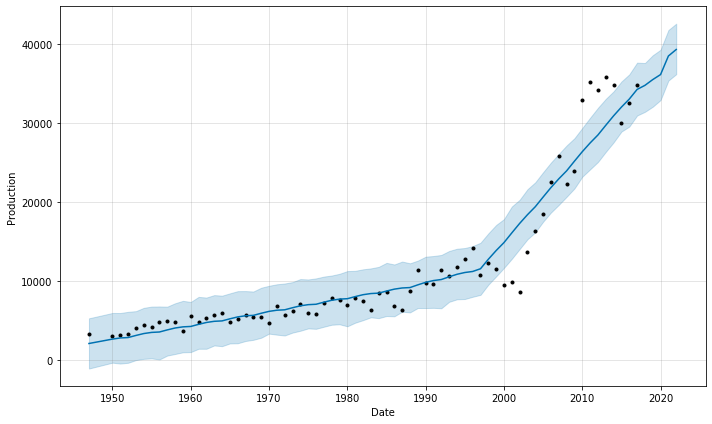

In [33]:
# Plot the future for next 5 years.

figure = m.plot(forecast, xlabel ='Date', ylabel = 'Production')

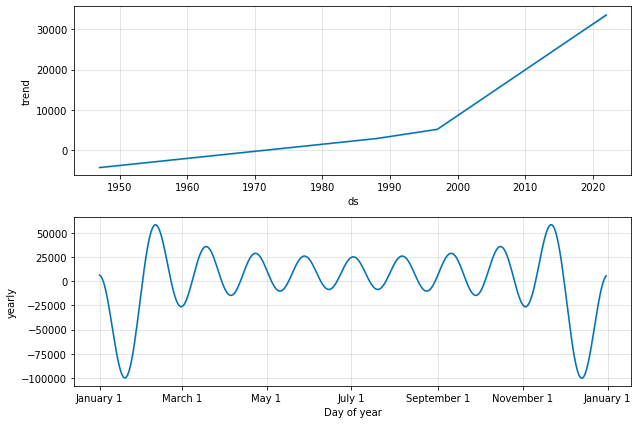

In [34]:
# Plot the components.

figure = m.plot_components(forecast)

In [36]:
df3['Prediction']=forecast.yhat
df3['Error']= (df3.y-df3.Prediction.abs())
df3.tail()

,ds,y,Prediction,Error
64,2013-01-01,35902,29767.938024,6134.061976
65,2014-01-01,34805,30966.745710,3838.254290
66,2015-01-01,30005,32071.266631,-2066.266631
67,2016-01-01,32577,33081.547919,-504.547919
68,2017-01-01,34862,34308.031071,553.968929


In [25]:
# Print the MAE and RMSE values.

MAE = df3["Error"].abs().mean()  
print("MAE:",round(MAE,2)) 
RMSE = np.sqrt((df3["Error"]**2).mean())
print("RMSE:",round(RMSE,2))

MAE: 5180.32
RMSE: 5982.91


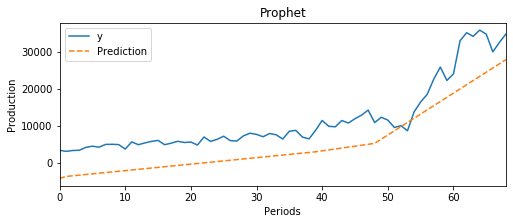

In [26]:
# Plot the Values

df3.index.name = "Periods"
df3[["y","Prediction"]].plot(figsize=(8,3),title="Prophet",style=["-","--"])  
plt.ylabel("Production")
plt.show()

# LSTM Model

In [323]:
train, test = df1[:-12],df1[-12:]
test

,Production
Year,
2006-01-01,22632
2007-01-01,25884
2008-01-01,22276
2009-01-01,24022
2010-01-01,33000
2011-01-01,35200
2012-01-01,34220
2013-01-01,35902
2014-01-01,34805


In [324]:
# Scale the data using Minmax scaler

scalar =MinMaxScaler()
scalar.fit(train)
train = scalar.transform(train)
test = scalar.transform(test)

In [325]:
# Create a time series generator.

n_input =12
n_features = 1
generator = TimeseriesGenerator(train, train, n_input, batch_size =6)
generator
train.shape

(57, 1)

In [326]:
print('Samples: %d' % len(generator))

Samples: 8


# Part 1: epochs =180, optimizer = adam

In [327]:
model = Sequential()
# Adding the input layer and LSTM layer
model.add(LSTM(200, activation= 'relu', input_shape =(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer ='adam', loss='mse',metrics = ['acc'])
model.fit_generator(generator, epochs =180)

Epoch 1/180
8/8 [==============================] - 0s 53ms/step - loss: 0.1254 - acc: 0.0000e+00
Epoch 2/180
8/8 [==============================] - 0s 18ms/step - loss: 0.0430 - acc: 0.0222
Epoch 3/180
8/8 [==============================] - 0s 15ms/step - loss: 0.0222 - acc: 0.0222
Epoch 4/180
8/8 [==============================] - 0s 20ms/step - loss: 0.0327 - acc: 0.0222
Epoch 5/180
8/8 [==============================] - 0s 16ms/step - loss: 0.0242 - acc: 0.0222
Epoch 6/180
8/8 [==============================] - 0s 20ms/step - loss: 0.0152 - acc: 0.0222
Epoch 7/180
8/8 [==============================] - 0s 20ms/step - loss: 0.0162 - acc: 0.0222
Epoch 8/180
8/8 [==============================] - 0s 18ms/step - loss: 0.0181 - acc: 0.0222
Epoch 9/180
8/8 [==============================] - 0s 15ms/step - loss: 0.0168 - acc: 0.0222
Epoch 10/180
8/8 [==============================] - 0s 19ms/step - loss: 0.0162 - acc: 0.0222
Epoch 11/180
8/8 [==============================] - 0s 18ms/step 

8/8 [==============================] - 0s 12ms/step - loss: 0.0090 - acc: 0.0222
Epoch 175/180
8/8 [==============================] - 0s 12ms/step - loss: 0.0198 - acc: 0.0222
Epoch 176/180
8/8 [==============================] - 0s 13ms/step - loss: 0.0121 - acc: 0.0222
Epoch 177/180
8/8 [==============================] - 0s 12ms/step - loss: 0.0086 - acc: 0.0222
Epoch 178/180
8/8 [==============================] - 0s 12ms/step - loss: 0.0104 - acc: 0.0222
Epoch 179/180
8/8 [==============================] - 0s 14ms/step - loss: 0.0135 - acc: 0.0222
Epoch 180/180
8/8 [==============================] - 0s 14ms/step - loss: 0.0120 - acc: 0.0222


In [328]:
pred_list =[]
batch = train[-n_input:].reshape(1, n_input, n_features)
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)
pred_list

[array([1.1744066], dtype=float32),
 array([1.2067055], dtype=float32),
 array([1.1609579], dtype=float32),
 array([1.0416677], dtype=float32),
 array([1.0144334], dtype=float32),
 array([1.0980121], dtype=float32),
 array([1.2938988], dtype=float32),
 array([1.6280824], dtype=float32),
 array([2.113015], dtype=float32),
 array([2.7816758], dtype=float32),
 array([3.4271464], dtype=float32),
 array([3.8514225], dtype=float32)]

In [329]:
test1=pd.DataFrame(scalar.inverse_transform(test),index= df1[-n_input:].index, columns =['Production'])
test1

,Production
Year,
2006-01-01,22632.0
2007-01-01,25884.0
2008-01-01,22276.0
2009-01-01,24022.0
2010-01-01,33000.0
2011-01-01,35200.0
2012-01-01,34220.0
2013-01-01,35902.0
2014-01-01,34805.0


In [330]:
df_predict= pd.DataFrame(scalar.inverse_transform(pred_list), index= df1[-n_input:].index, columns =['Predictions'])
df_predict

,Predictions
Year,
2006-01-01,21194.454740
2007-01-01,21693.632745
2008-01-01,20986.604846
2009-01-01,19142.974301
2010-01-01,18722.067949
2011-01-01,20013.776847
2012-01-01,23041.206277
2013-01-01,28206.013409
2014-01-01,35700.645843


In [331]:
df_test = pd.concat([test1, df_predict], axis =1)
df_test

,Production,Predictions
Year,,
2006-01-01,22632.0,21194.454740
2007-01-01,25884.0,21693.632745
2008-01-01,22276.0,20986.604846
2009-01-01,24022.0,19142.974301
2010-01-01,33000.0,18722.067949
2011-01-01,35200.0,20013.776847
2012-01-01,34220.0,23041.206277
2013-01-01,35902.0,28206.013409
2014-01-01,34805.0,35700.645843


In [332]:
df_test1 = pd.concat([df1, df_predict], axis =1)
df_test1.tail()

,Production,Predictions
Year,,
2013-01-01,35902,28206.013409
2014-01-01,34805,35700.645843
2015-01-01,30005,46034.799730
2016-01-01,32577,56010.548150
2017-01-01,34862,62567.735484


In [333]:
# Print the MAE and RMSE values.

MAE = mean_absolute_error(df_test.Production,df_test.Predictions)
print("MAE:",round(MAE,2))
RMSE = math.sqrt(mean_squared_error(df_test.Production,df_test.Predictions))
print("RMSE:",round(RMSE,2))

MAE: 10683.33
RMSE: 13657.3


Text(0, 0.5, 'Production')

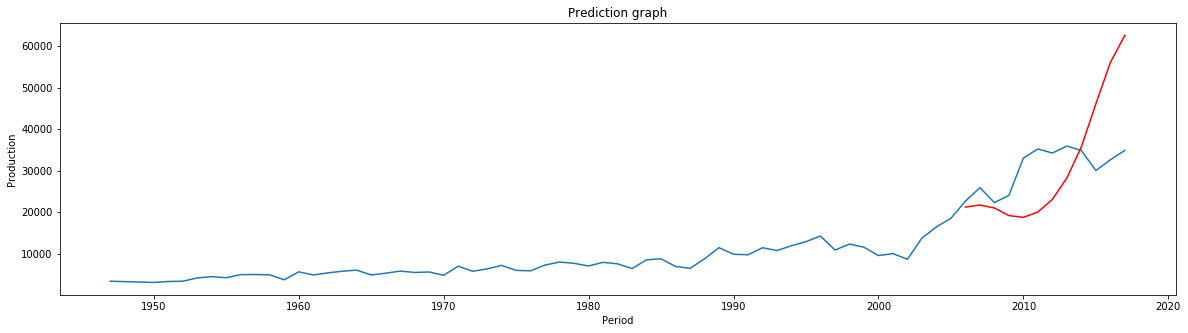

In [334]:
# Plot the Values

plt.figure(figsize=(20,5))
plt.plot(df_test1.index, df_test1['Production'])
plt.plot(df_test1.index, df_test1['Predictions'], color ='r')
plt.title("Prediction graph")
plt.xlabel("Period")
plt.ylabel("Production")

In [335]:
# Forecast for 12 years

train_1 = df1
scalar.fit(train_1)
train_1 = scalar.transform(train_1)
n_input =12
n_features = 1
generator = TimeseriesGenerator(train_1, train_1, n_input, batch_size =6)
model.fit_generator(generator, epochs =180)

Epoch 1/180
10/10 [==============================] - 0s 17ms/step - loss: 0.0180 - acc: 0.0175
Epoch 2/180
10/10 [==============================] - 0s 15ms/step - loss: 0.0136 - acc: 0.0175
Epoch 3/180
10/10 [==============================] - 0s 13ms/step - loss: 0.0097 - acc: 0.0175
Epoch 4/180
10/10 [==============================] - 0s 13ms/step - loss: 0.0133 - acc: 0.0175
Epoch 5/180
10/10 [==============================] - 0s 20ms/step - loss: 0.0085 - acc: 0.0175 
Epoch 6/180
10/10 [==============================] - 0s 15ms/step - loss: 0.0079 - acc: 0.0175
Epoch 7/180
10/10 [==============================] - 0s 13ms/step - loss: 0.0092 - acc: 0.0175
Epoch 8/180
10/10 [==============================] - 0s 13ms/step - loss: 0.0120 - acc: 0.0175 
Epoch 9/180
10/10 [==============================] - 0s 13ms/step - loss: 0.0130 - acc: 0.0175 
Epoch 10/180
10/10 [==============================] - 0s 15ms/step - loss: 0.0103 - acc: 0.0175
Epoch 11/180
10/10 [==========================

10/10 [==============================] - 0s 14ms/step - loss: 0.0029 - acc: 0.0175 
Epoch 171/180
10/10 [==============================] - 0s 16ms/step - loss: 0.0025 - acc: 0.0175 
Epoch 172/180
10/10 [==============================] - 0s 12ms/step - loss: 0.0035 - acc: 0.0175   
Epoch 173/180
10/10 [==============================] - 0s 13ms/step - loss: 0.0055 - acc: 0.0175  
Epoch 174/180
10/10 [==============================] - 0s 12ms/step - loss: 0.0032 - acc: 0.0175  
Epoch 175/180
10/10 [==============================] - 0s 13ms/step - loss: 0.0037 - acc: 0.0175
Epoch 176/180
10/10 [==============================] - 0s 14ms/step - loss: 0.0056 - acc: 0.0175 
Epoch 177/180
10/10 [==============================] - 0s 13ms/step - loss: 0.0041 - acc: 0.0175  
Epoch 178/180
10/10 [==============================] - 0s 13ms/step - loss: 0.0029 - acc: 0.0175
Epoch 179/180
10/10 [==============================] - 0s 14ms/step - loss: 0.0036 - acc: 0.0175
Epoch 180/180
10/10 [===========

In [336]:
pred_list =[]
batch = train_1[-n_input:].reshape(1, n_input, n_features)
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)
    
from pandas.tseries.offsets import DateOffset
add_dates =[df1.index[-1] + DateOffset(years=x) for x in range(0,13)]
future_dates = pd.DataFrame(index=add_dates[1:], columns=df1.columns)
future_dates.tail()

,Production
2025-01-01,NaN
2026-01-01,NaN
2027-01-01,NaN
2028-01-01,NaN
2029-01-01,NaN


In [337]:
future_dates

,Production
2018-01-01,NaN
2019-01-01,NaN
2020-01-01,NaN
2021-01-01,NaN
2022-01-01,NaN
2023-01-01,NaN
2024-01-01,NaN
2025-01-01,NaN
2026-01-01,NaN
2027-01-01,NaN


In [338]:
df_predict= pd.DataFrame(scalar.inverse_transform(pred_list), index= future_dates[-n_input:].index, columns =['Predictions'])
df_test_1 = pd.concat([df1, df_predict], axis =1)
df_test.tail()

,Production,Predictions
Year,,
2013-01-01,35902.0,28206.013409
2014-01-01,34805.0,35700.645843
2015-01-01,30005.0,46034.799730
2016-01-01,32577.0,56010.548150
2017-01-01,34862.0,62567.735484


Text(0, 0.5, 'Production')

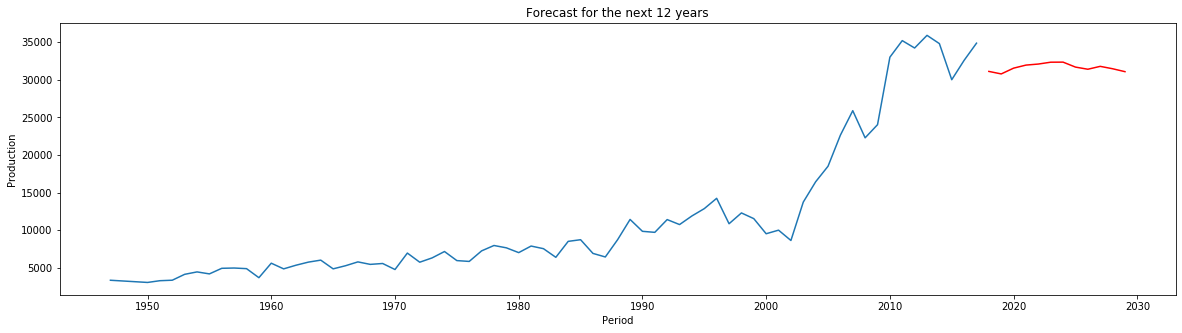

In [339]:
# Plot the Future

plt.figure(figsize=(20,5))
plt.plot(df_test_1.index, df_test_1['Production'])
plt.plot(df_test_1.index, df_test_1['Predictions'], color ='r')
plt.title("Forecast for the next 12 years")
plt.xlabel("Period")
plt.ylabel("Production")

# Part 2: epochs = 250 , optimizer = Adagrad

In [340]:
model = Sequential()
# Adding the input layer and LSTM layer
model.add(LSTM(200, activation= 'relu', input_shape =(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer ='adagrad', loss='mse',metrics = ['acc'])
model.fit_generator(generator, epochs =250)

Epoch 1/250
10/10 [==============================] - 0s 41ms/step - loss: 0.1182 - acc: 0.0000e+00
Epoch 2/250
10/10 [==============================] - 0s 13ms/step - loss: 0.0404 - acc: 0.0175  
Epoch 3/250
10/10 [==============================] - 0s 14ms/step - loss: 0.0229 - acc: 0.0175
Epoch 4/250
10/10 [==============================] - 0s 12ms/step - loss: 0.0240 - acc: 0.0175
Epoch 5/250
10/10 [==============================] - 0s 14ms/step - loss: 0.1031 - acc: 0.0000e+00
Epoch 6/250
10/10 [==============================] - 0s 14ms/step - loss: 0.0332 - acc: 0.0175 
Epoch 7/250
10/10 [==============================] - 0s 13ms/step - loss: 0.0291 - acc: 0.0175  
Epoch 8/250
10/10 [==============================] - 0s 12ms/step - loss: 0.0332 - acc: 0.0175
Epoch 9/250
10/10 [==============================] - 0s 13ms/step - loss: 0.0360 - acc: 0.0000e+00
Epoch 10/250
10/10 [==============================] - 0s 12ms/step - loss: 0.0174 - acc: 0.0175
Epoch 11/250
10/10 [============

10/10 [==============================] - 0s 14ms/step - loss: 0.0081 - acc: 0.0175  
Epoch 170/250
10/10 [==============================] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+0 - 0s 12ms/step - loss: 0.0068 - acc: 0.0175
Epoch 171/250
10/10 [==============================] - 0s 12ms/step - loss: 0.0055 - acc: 0.0175
Epoch 172/250
10/10 [==============================] - 0s 16ms/step - loss: 0.0079 - acc: 0.0175 
Epoch 173/250
10/10 [==============================] - 0s 16ms/step - loss: 0.0059 - acc: 0.0175
Epoch 174/250
10/10 [==============================] - 0s 16ms/step - loss: 0.0062 - acc: 0.0175
Epoch 175/250
10/10 [==============================] - 0s 13ms/step - loss: 0.0049 - acc: 0.0175
Epoch 176/250
10/10 [==============================] - 0s 12ms/step - loss: 0.0073 - acc: 0.0175
Epoch 177/250
10/10 [==============================] - 0s 16ms/step - loss: 0.0077 - acc: 0.0175
Epoch 178/250
10/10 [==============================] - 0s 13ms/step - loss: 0.0059 - acc: 0.0175

In [341]:
pred_list =[]
batch = train[-n_input:].reshape(1, n_input, n_features)
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)
pred_list

[array([0.8215341], dtype=float32),
 array([0.84504277], dtype=float32),
 array([0.86639345], dtype=float32),
 array([0.8818867], dtype=float32),
 array([0.89044553], dtype=float32),
 array([0.8924626], dtype=float32),
 array([0.890423], dtype=float32),
 array([0.880193], dtype=float32),
 array([0.86953026], dtype=float32),
 array([0.8508967], dtype=float32),
 array([0.84192085], dtype=float32),
 array([0.8364386], dtype=float32)]

In [342]:

df_predict= pd.DataFrame(scalar.inverse_transform(pred_list), index= df1[-n_input:].index, columns =['Predictions'])
df_predict

,Predictions
Year,
2006-01-01,30037.967366
2007-01-01,30810.415177
2008-01-01,31511.955879
2009-01-01,32021.033867
2010-01-01,32302.259238
2011-01-01,32368.536479
2012-01-01,32301.518929
2013-01-01,31965.381432
2014-01-01,31615.025302


In [343]:
df_test = pd.concat([test1, df_predict], axis =1)
df_test

,Production,Predictions
Year,,
2006-01-01,22632.0,30037.967366
2007-01-01,25884.0,30810.415177
2008-01-01,22276.0,31511.955879
2009-01-01,24022.0,32021.033867
2010-01-01,33000.0,32302.259238
2011-01-01,35200.0,32368.536479
2012-01-01,34220.0,32301.518929
2013-01-01,35902.0,31965.381432
2014-01-01,34805.0,31615.025302


In [344]:
df_test1 = pd.concat([df1, df_predict], axis =1)
df_test1.tail()

,Production,Predictions
Year,,
2013-01-01,35902,31965.381432
2014-01-01,34805,31615.025302
2015-01-01,30005,31002.764298
2016-01-01,32577,30707.835377
2017-01-01,34862,30527.699396


In [345]:
# Print the MAE and RMSE values.

MAE = mean_absolute_error(df_test.Production,df_test.Predictions)
print("MAE:",round(MAE,2))
RMSE = math.sqrt(mean_squared_error(df_test.Production,df_test.Predictions))
print("RMSE:",round(RMSE,2))

MAE: 4111.91
RMSE: 4912.05


Text(0, 0.5, 'Production')

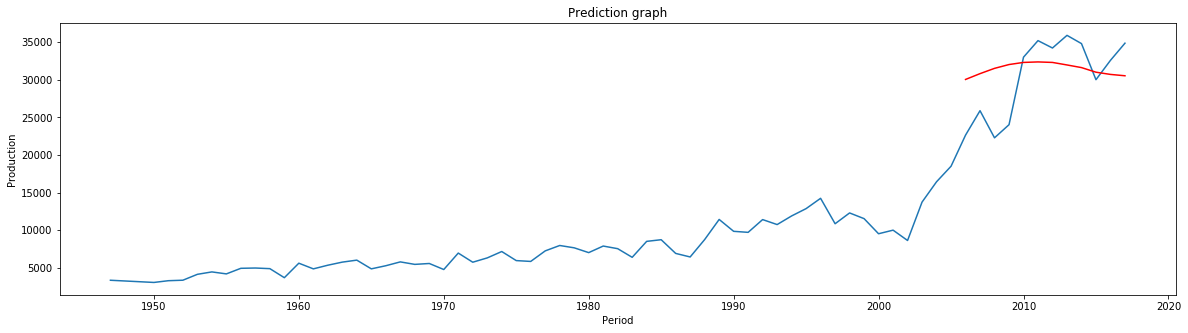

In [346]:
# Plot the Values

plt.figure(figsize=(20,5))
plt.plot(df_test1.index, df_test1['Production'])
plt.plot(df_test1.index, df_test1['Predictions'], color ='r')
plt.title("Prediction graph")
plt.xlabel("Period")
plt.ylabel("Production")

In [347]:
# Forecast for the next 12 years

train_1 = df1
scalar.fit(train_1)
train_1 = scalar.transform(train_1)
n_input =12
n_features = 1
generator = TimeseriesGenerator(train_1, train_1, n_input, batch_size =6)
model.fit_generator(generator, epochs =250)

Epoch 1/250
10/10 [==============================] - 0s 14ms/step - loss: 0.0042 - acc: 0.0175
Epoch 2/250
10/10 [==============================] - 0s 14ms/step - loss: 0.0047 - acc: 0.0175
Epoch 3/250
10/10 [==============================] - 0s 14ms/step - loss: 0.0043 - acc: 0.0175  
Epoch 4/250
10/10 [==============================] - 0s 14ms/step - loss: 0.0039 - acc: 0.0175 
Epoch 5/250
10/10 [==============================] - 0s 13ms/step - loss: 0.0045 - acc: 0.0175
Epoch 6/250
10/10 [==============================] - 0s 18ms/step - loss: 0.0046 - acc: 0.0175
Epoch 7/250
10/10 [==============================] - 0s 17ms/step - loss: 0.0038 - acc: 0.0175
Epoch 8/250
10/10 [==============================] - 0s 16ms/step - loss: 0.0038 - acc: 0.0175
Epoch 9/250
10/10 [==============================] - 0s 16ms/step - loss: 0.0048 - acc: 0.0175
Epoch 10/250
10/10 [==============================] - 0s 17ms/step - loss: 0.0038 - acc: 0.0175 
Epoch 11/250
10/10 [=========================

10/10 [==============================] - 0s 17ms/step - loss: 0.0029 - acc: 0.0175
Epoch 87/250
10/10 [==============================] - 0s 17ms/step - loss: 0.0045 - acc: 0.0175
Epoch 88/250
10/10 [==============================] - 0s 18ms/step - loss: 0.0036 - acc: 0.0175
Epoch 89/250
10/10 [==============================] - 0s 15ms/step - loss: 0.0042 - acc: 0.0175 
Epoch 90/250
10/10 [==============================] - 0s 15ms/step - loss: 0.0035 - acc: 0.0175
Epoch 91/250
10/10 [==============================] - 0s 13ms/step - loss: 0.0035 - acc: 0.0175  
Epoch 92/250
10/10 [==============================] - 0s 12ms/step - loss: 0.0036 - acc: 0.0175
Epoch 93/250
10/10 [==============================] - 0s 12ms/step - loss: 0.0044 - acc: 0.0175
Epoch 94/250
10/10 [==============================] - 0s 14ms/step - loss: 0.0030 - acc: 0.0175
Epoch 95/250
10/10 [==============================] - 0s 12ms/step - loss: 0.0033 - acc: 0.0175  
Epoch 96/250
10/10 [============================

In [348]:
pred_list =[]
batch = train_1[-n_input:].reshape(1, n_input, n_features)
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)
    
from pandas.tseries.offsets import DateOffset
add_dates =[df1.index[-1] + DateOffset(years=x) for x in range(0,13)]
future_dates = pd.DataFrame(index=add_dates[1:], columns=df1.columns)
future_dates.tail()

,Production
2025-01-01,NaN
2026-01-01,NaN
2027-01-01,NaN
2028-01-01,NaN
2029-01-01,NaN


In [349]:
df_predict= pd.DataFrame(scalar.inverse_transform(pred_list), index= future_dates[-n_input:].index, columns =['Predictions'])
df_test_1 = pd.concat([df1, df_predict], axis =1)
df_test.tail()

,Production,Predictions
Year,,
2013-01-01,35902.0,31965.381432
2014-01-01,34805.0,31615.025302
2015-01-01,30005.0,31002.764298
2016-01-01,32577.0,30707.835377
2017-01-01,34862.0,30527.699396


Text(0, 0.5, 'Production')

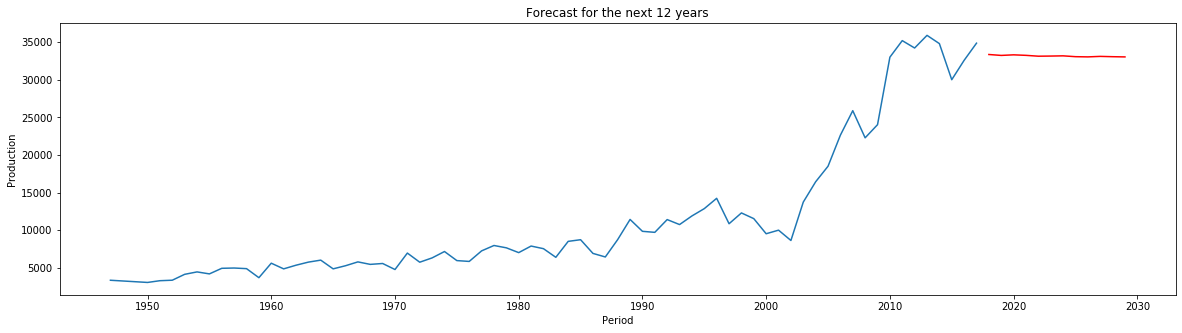

In [350]:
# Plot the Future

plt.figure(figsize=(20,5))
plt.plot(df_test_1.index, df_test_1['Production'])
plt.plot(df_test_1.index, df_test_1['Predictions'], color ='r')
plt.title("Forecast for the next 12 years")
plt.xlabel("Period")
plt.ylabel("Production")

# Part 3 : epochs = 300 , optimizer = sgd 

In [351]:
model = Sequential()
# Adding the input layer and LSTM layer
model.add(LSTM(200, activation= 'relu', input_shape =(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer ='sgd', loss='mse',metrics = ['acc'])
model.fit_generator(generator, epochs =300)

Epoch 1/300
10/10 [==============================] - 1s 53ms/step - loss: 0.1652 - acc: 0.0000e+00
Epoch 2/300
10/10 [==============================] - 0s 15ms/step - loss: 0.1121 - acc: 0.0000e+00
Epoch 3/300
10/10 [==============================] - 0s 14ms/step - loss: 0.0895 - acc: 0.0000e+00
Epoch 4/300
10/10 [==============================] - 0s 16ms/step - loss: 0.0746 - acc: 0.0000e+00
Epoch 5/300
10/10 [==============================] - 0s 15ms/step - loss: 0.0694 - acc: 0.0000e+00
Epoch 6/300
10/10 [==============================] - 0s 15ms/step - loss: 0.0611 - acc: 0.0000e+00
Epoch 7/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0608 - acc: 0.0000e+00
Epoch 8/300
10/10 [==============================] - 0s 15ms/step - loss: 0.0609 - acc: 0.0000e+00
Epoch 9/300
10/10 [==============================] - 0s 15ms/step - loss: 0.0570 - acc: 0.0000e+00
Epoch 10/300
10/10 [==============================] - 0s 14ms/step - loss: 0.0520 - acc: 0.0175
Epoch 11/300


10/10 [==============================] - 0s 12ms/step - loss: 0.0072 - acc: 0.0175
Epoch 170/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0076 - acc: 0.0175  
Epoch 171/300
10/10 [==============================] - 0s 14ms/step - loss: 0.0087 - acc: 0.0175
Epoch 172/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0061 - acc: 0.0175  
Epoch 173/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0096 - acc: 0.0175
Epoch 174/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0090 - acc: 0.0175
Epoch 175/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0071 - acc: 0.0175  
Epoch 176/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0102 - acc: 0.0175  
Epoch 177/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0098 - acc: 0.0175  
Epoch 178/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0089 - acc: 0.0175
Epoch 179/300
10/10 [=============

10/10 [==============================] - 0s 13ms/step - loss: 0.0078 - acc: 0.0175
Epoch 254/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0072 - acc: 0.0175  
Epoch 255/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0084 - acc: 0.0175
Epoch 256/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0083 - acc: 0.0175  
Epoch 257/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0082 - acc: 0.0175  
Epoch 258/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0079 - acc: 0.0175
Epoch 259/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0087 - acc: 0.0175  
Epoch 260/300
10/10 [==============================] - 0s 17ms/step - loss: 0.0093 - acc: 0.0175 
Epoch 261/300
10/10 [==============================] - 0s 17ms/step - loss: 0.0105 - acc: 0.0175 
Epoch 262/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0072 - acc: 0.0175
Epoch 263/300
10/10 [=============

In [352]:
pred_list =[]
batch = train[-n_input:].reshape(1, n_input, n_features)
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)
pred_list

[array([0.81289095], dtype=float32),
 array([0.83993506], dtype=float32),
 array([0.8677263], dtype=float32),
 array([0.89477146], dtype=float32),
 array([0.92478687], dtype=float32),
 array([0.9536718], dtype=float32),
 array([0.9834764], dtype=float32),
 array([1.0154359], dtype=float32),
 array([1.047195], dtype=float32),
 array([1.0805427], dtype=float32),
 array([1.109848], dtype=float32),
 array([1.1374388], dtype=float32)]

In [353]:
df_predict= pd.DataFrame(scalar.inverse_transform(pred_list), index= df1[-n_input:].index, columns =['Predictions'])
df_predict

,Predictions
Year,
2006-01-01,29753.970732
2007-01-01,30642.586343
2008-01-01,31555.751619
2009-01-01,32444.400525
2010-01-01,33430.646834
2011-01-01,34379.748432
2012-01-01,35359.067564
2013-01-01,36409.193922
2014-01-01,37452.731921


In [354]:
df_test = pd.concat([test1, df_predict], axis =1)
df_test

,Production,Predictions
Year,,
2006-01-01,22632.0,29753.970732
2007-01-01,25884.0,30642.586343
2008-01-01,22276.0,31555.751619
2009-01-01,24022.0,32444.400525
2010-01-01,33000.0,33430.646834
2011-01-01,35200.0,34379.748432
2012-01-01,34220.0,35359.067564
2013-01-01,35902.0,36409.193922
2014-01-01,34805.0,37452.731921


In [355]:
df_test1 = pd.concat([df1, df_predict], axis =1)
df_test1.tail()


,Production,Predictions
Year,,
2013-01-01,35902,36409.193922
2014-01-01,34805,37452.731921
2015-01-01,30005,38548.471498
2016-01-01,32577,39511.386322
2017-01-01,34862,40417.963240


In [356]:
# Print the MAE and RMSE values.

MAE = mean_absolute_error(df_test.Production,df_test.Predictions)
print("MAE:",round(MAE,2))
RMSE = math.sqrt(mean_squared_error(df_test.Production,df_test.Predictions))
print("RMSE:",round(RMSE,2))

MAE: 4680.12
RMSE: 5713.92


Text(0, 0.5, 'Production')

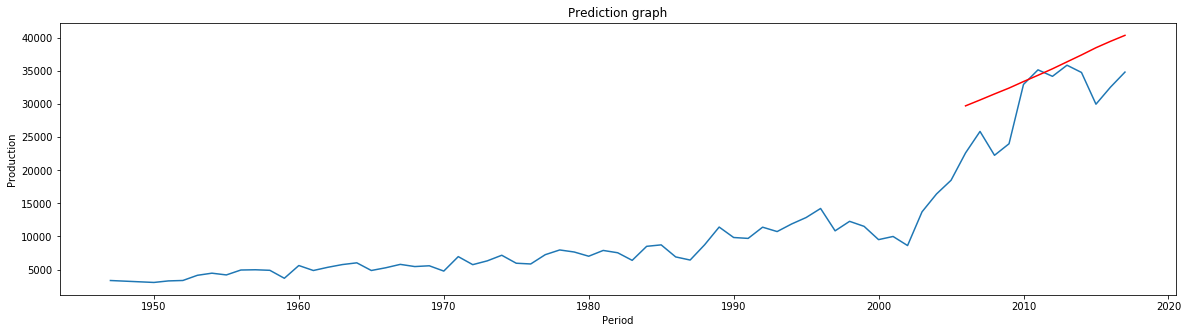

In [357]:
# Plot the Values

plt.figure(figsize=(20,5))
plt.plot(df_test1.index, df_test1['Production'])
plt.plot(df_test1.index, df_test1['Predictions'], color ='r')
plt.title("Prediction graph")
plt.xlabel("Period")
plt.ylabel("Production")

In [358]:
# Forecast for 12 years

train_1 = df1
scalar.fit(train_1)
train_1 = scalar.transform(train_1)
n_input =12
n_features = 1
generator = TimeseriesGenerator(train_1, train_1, n_input, batch_size =6)
model.fit_generator(generator, epochs =300)

Epoch 1/300
10/10 [==============================] - 0s 14ms/step - loss: 0.0080 - acc: 0.0175 
Epoch 2/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0092 - acc: 0.0175 
Epoch 3/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0092 - acc: 0.0175  
Epoch 4/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0076 - acc: 0.0175
Epoch 5/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0081 - acc: 0.0175
Epoch 6/300
10/10 [==============================] - 0s 16ms/step - loss: 0.0069 - acc: 0.0175
Epoch 7/300
10/10 [==============================] - 0s 14ms/step - loss: 0.0090 - acc: 0.0175 
Epoch 8/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0080 - acc: 0.0175
Epoch 9/300
10/10 [==============================] - 0s 18ms/step - loss: 0.0094 - acc: 0.0175
Epoch 10/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0076 - acc: 0.0175  
Epoch 11/300
10/10 [======================

10/10 [==============================] - 0s 12ms/step - loss: 0.0089 - acc: 0.0175
Epoch 170/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0077 - acc: 0.0175  
Epoch 171/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0072 - acc: 0.0175  
Epoch 172/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0062 - acc: 0.0175
Epoch 173/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0084 - acc: 0.0175
Epoch 174/300
10/10 [==============================] - 0s 14ms/step - loss: 0.0081 - acc: 0.0175
Epoch 175/300
10/10 [==============================] - 0s 14ms/step - loss: 0.0065 - acc: 0.0175
Epoch 176/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0088 - acc: 0.0175  
Epoch 177/300
10/10 [==============================] - 0s 13ms/step - loss: 0.0080 - acc: 0.0175
Epoch 178/300
10/10 [==============================] - 0s 15ms/step - loss: 0.0062 - acc: 0.0175 
Epoch 179/300
10/10 [================

In [359]:
pred_list =[]
batch = train_1[-n_input:].reshape(1, n_input, n_features)
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)
    
from pandas.tseries.offsets import DateOffset
add_dates =[df1.index[-1] + DateOffset(years=x) for x in range(0,13)]
future_dates = pd.DataFrame(index=add_dates[1:], columns=df1.columns)
future_dates.tail()

,Production
2025-01-01,NaN
2026-01-01,NaN
2027-01-01,NaN
2028-01-01,NaN
2029-01-01,NaN


In [360]:
future_dates

,Production
2018-01-01,NaN
2019-01-01,NaN
2020-01-01,NaN
2021-01-01,NaN
2022-01-01,NaN
2023-01-01,NaN
2024-01-01,NaN
2025-01-01,NaN
2026-01-01,NaN
2027-01-01,NaN


In [361]:
df_predict= pd.DataFrame(scalar.inverse_transform(pred_list), index= future_dates[-n_input:].index, columns =['Predictions'])
df_test_1 = pd.concat([df1, df_predict], axis =1)
df_test.tail()

,Production,Predictions
Year,,
2013-01-01,35902.0,36409.193922
2014-01-01,34805.0,37452.731921
2015-01-01,30005.0,38548.471498
2016-01-01,32577.0,39511.386322
2017-01-01,34862.0,40417.963240


Text(0, 0.5, 'Production')

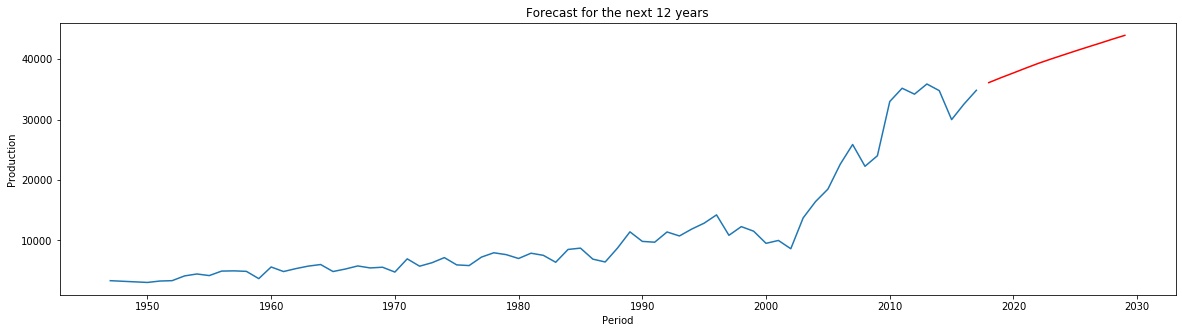

In [362]:
# Plot the Future

plt.figure(figsize=(20,5))
plt.plot(df_test_1.index, df_test_1['Production'])
plt.plot(df_test_1.index, df_test_1['Predictions'], color ='r')
plt.title("Forecast for the next 12 years")
plt.xlabel("Period")
plt.ylabel("Production")